In [1]:
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
import os 
from tslearn.datasets import UCR_UEA_datasets

# Parameters

In [2]:
dataset='BasicMotions'#'GunPoint'

# Load Data

In [3]:
X_train,y_train, X_test, y_test=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])
train_y = y_train
test_y=y_test


In [4]:
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
#pickle.dump(enc1,open(f'./ClassificationModels/models/{dataset}/OneHotEncoder.pkl','wb'))
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [5]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=6, num_pred_classes=n_pred_classes)
fit(model,train_loader,test_loader)
if dataset in os.listdir('../../ClassificationModels/models/'):
    print('Folder exists')
else: 
    os.mkdir(f'../../ClassificationModels/models/{dataset}')
torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/ResNet')
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()

test_preds, ground_truth = get_all_preds(model, test_loader)
ground_truth=np.argmax(ground_truth,axis=1)

sns.set(rc={'figure.figsize':(5,4)})
heatmap=confusion_matrix(ground_truth, test_preds)
sns.heatmap(heatmap, annot=True)
plt.savefig(f'../../ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
plt.close()
acc= accuracy_score(ground_truth, test_preds)
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'../../ClassificationModels/models/{dataset}/classification_report.csv', index = False)

Epoch: 1, Train loss: 1.199, Val loss: 1.199
Epoch: 2, Train loss: 1.185, Val loss: 1.048
Epoch: 3, Train loss: 0.979, Val loss: 0.938
Epoch: 4, Train loss: 0.847, Val loss: 0.764
Epoch: 5, Train loss: 0.692, Val loss: 0.62
Epoch: 6, Train loss: 0.574, Val loss: 0.475
Epoch: 7, Train loss: 0.415, Val loss: 0.373
Epoch: 8, Train loss: 0.293, Val loss: 0.205
Epoch: 9, Train loss: 0.136, Val loss: 0.837
Epoch: 10, Train loss: 0.046, Val loss: 0.833
Epoch: 11, Train loss: 0.076, Val loss: 0.566
Epoch: 12, Train loss: 0.165, Val loss: 0.212
Epoch: 13, Train loss: 0.113, Val loss: 0.036
Epoch: 14, Train loss: 0.019, Val loss: 0.195
Epoch: 15, Train loss: 0.114, Val loss: 0.17
Epoch: 16, Train loss: 0.006, Val loss: 0.122
Epoch: 17, Train loss: 0.017, Val loss: 0.19
Epoch: 18, Train loss: 0.009, Val loss: 0.618
Epoch: 19, Train loss: 0.002, Val loss: 1.737
Epoch: 20, Train loss: 0.003, Val loss: 2.85
Epoch: 21, Train loss: 0.005, Val loss: 0.384
Epoch: 22, Train loss: 0.001, Val loss: 0.031
E

KeyboardInterrupt: 

# Explanation Algo

In [ ]:
from TSInterpret.InterpretabilityModels.Saliency.SaliencyMethods_PTY import Saliency_PTY
int_mod=Saliency_PTY(model, train_x.shape[-1],train_x.shape[-2], method='GS',mode='feat')

2022-06-27 17:51:19.241584: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/cv2/../../lib64:
2022-06-27 17:51:19.241606: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Mode in Saliency feat


In [ ]:
item = np.array([test_x[0,:,:]])
label = int(np.argmax(test_y[0]))


In [ ]:
exp=int_mod.explain(item,labels=label,TSR = True)

In [ ]:
exp

array([[0.        , 0.00288084, 0.02465513, 0.0653208 , 0.03047273,
        0.        , 0.12615234, 0.34990699, 0.01375904, 0.02645088,
        0.00123491, 0.00911395, 0.0255229 , 0.07268517, 0.116407  ,
        0.45110507, 0.        , 0.44195045, 0.02892107, 0.0288556 ,
        0.14610171, 0.32789982, 0.03149887, 0.        , 0.02444592,
        0.01845658, 0.29020511, 0.41472818, 0.02697589, 0.01705946,
        0.09954992, 0.18494392, 0.00345619, 0.01497989, 0.02217925,
        0.02868241, 0.        , 0.01994573, 0.00762412, 0.34314732,
        0.0229846 , 0.02024661, 0.01309587, 0.02191767, 0.02941337,
        0.02422995, 0.00953341, 0.39469332, 0.02074583, 0.01950146,
        0.01944814, 0.        , 0.015924  , 0.02630379, 0.38257814,
        0.0015572 , 0.41377328, 0.04378224, 0.00679305, 0.35588923,
        0.39010251, 0.        , 0.38306633, 0.03234876, 0.02786976,
        0.02496887, 0.15084508, 0.00654371, 0.39193246, 0.02869956,
        0.25973089, 0.00954312, 0.03220126, 0.02

feat
NOT Time mode
-1
1
0
1
2
3
4
5


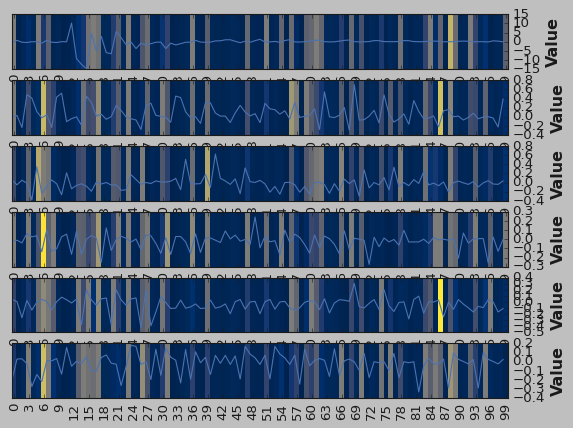

In [ ]:
int_mod.plot(np.array([test_x[0,:,:]]),exp, figsize=(30,30))

feat
NOT Time mode
-1
1


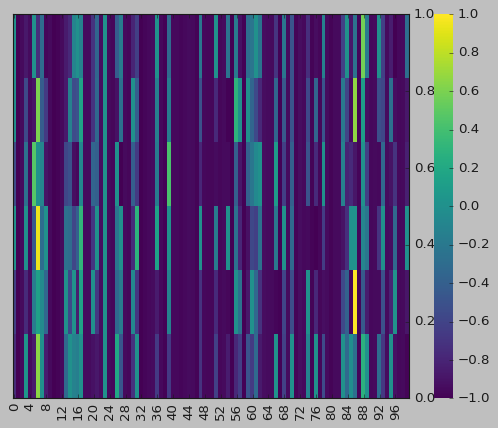

In [ ]:
int_mod.plot(np.array([test_x[0,:,:]]),exp, heatmap = True)